In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns;

In [2]:
base = pd.read_csv('dados/base_cidades.csv')

In [3]:
base.head()

,CITY,CAPITAL,IBGE_POP,IBGE_PLANTED_AREA,IDHM,ALT,AREA,PU_BANK
0,São Paulo,1,10463636.0,94.0,0.805,783.62,1521.11,8.0
1,Osasco,0,616068.0,0.0,0.780,742.97,64954.00,2.0
2,Rio De Janeiro,1,5426838.0,2098.0,0.799,11.80,1200255.00,5.0
3,Brasília,1,2450634.0,162894.0,0.820,1115.25,5760783.00,4.0
4,Porto Alegre,1,1339712.0,766.0,0.805,42.24,495.39,3.0


## Transformação dos dados
Como as variaveis estão em escala diferentes vamos colocalas na mesma escala para que a variação em cada variavel tenha um peso igual na clusterização

In [4]:
transformador = {}

for coluna in base.drop('CITY', axis=1).columns:
    min_max = MinMaxScaler().fit(base[[coluna]])
    base[coluna] = min_max.transform(base[[coluna]])
    transformador.update({ coluna:min_max })

/home/natan/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Clusterização
Vamos utilizar o algoritmo k-means, mas antes disso precismaos definir um numero de cluster ideal para essa base. O metodo escolhido para isso fo utilizando o grafico de cotovelo

In [5]:
distancia = []

for n_cluster in range(1, 21):
    kmeans = KMeans(n_clusters=n_cluster, random_state=12345).fit(base.drop('CITY', axis=1))
    
    distancia.append(
        sum(np.min(cdist(base.drop('CITY', axis=1), kmeans.cluster_centers_, 'euclidean'), axis=1)) / len(base.columns)
    )

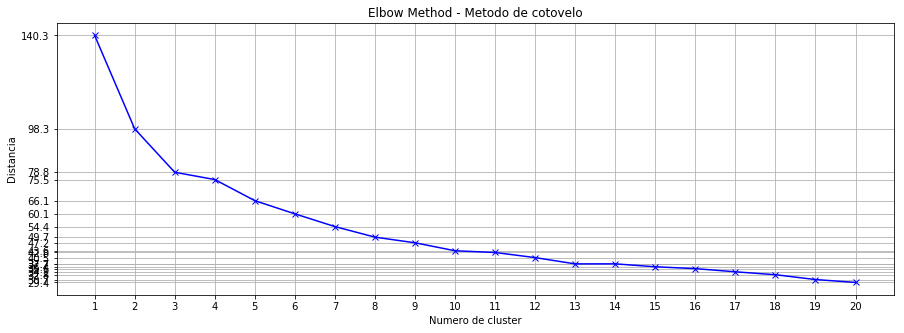

In [6]:
plt.figure(figsize=[15, 5])
plt.grid(True)

plt.xlabel('Numero de cluster')
plt.xticks(range(1, 21))

plt.ylabel('Distancia')
plt.yticks(distancia)

plt.title('Elbow Method - Metodo de cotovelo')

plt.plot(range(1, 21), distancia, 'bx-')
plt.show()

Olhando para o grafico, 3 clusters parece ser o numero ideal para fazermos a clusterização

In [7]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=12345)
kmeans = kmeans.fit(base.drop('CITY', axis=1))

In [8]:
base['CLUSTER'] = pd.Series(kmeans.predict(base.drop('CITY', axis=1)))

## Analise do grupos

Vamos voltar as variaveis as suas escalas normais para podermos entender como ficaram os clusters

In [9]:
for coluna in base.drop(['CITY', 'CLUSTER'], axis=1).columns:
    min_max = transformador[coluna]
    base[coluna] = np.round(min_max.inverse_transform(base[[coluna]]), 2)

Quantidade de pessoas em cada cluster

In [10]:
base.groupby(by='CLUSTER')['CITY'].count()

CLUSTER
0    1856
1    1210
2      27
3     588
4    1895
Name: CITY, dtype: int64

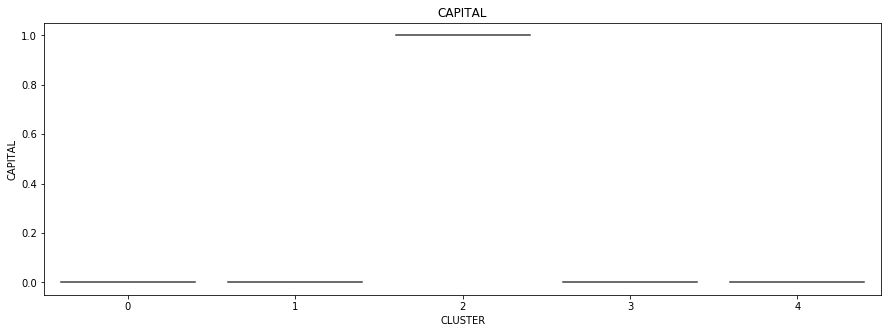

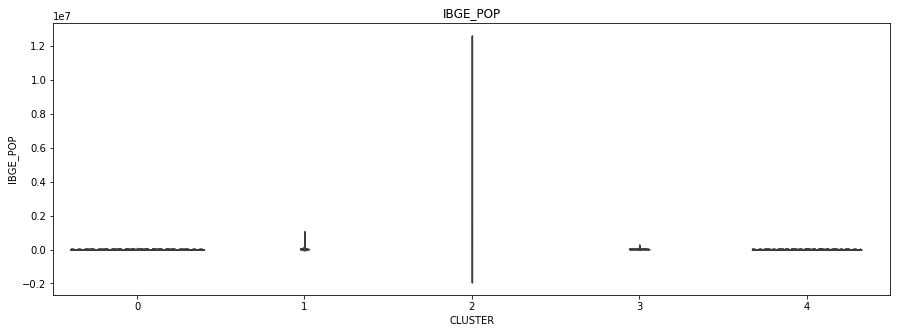

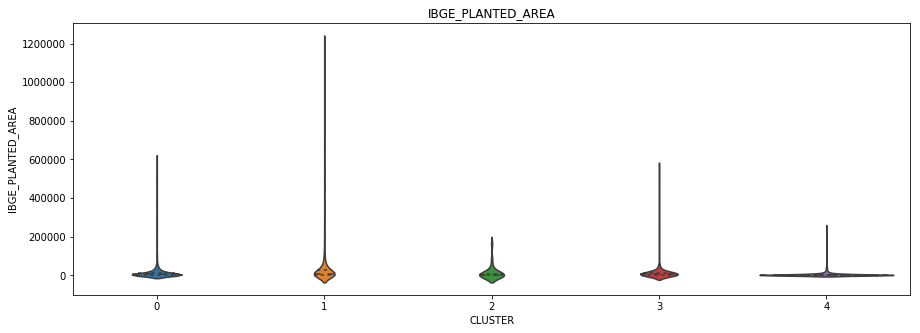

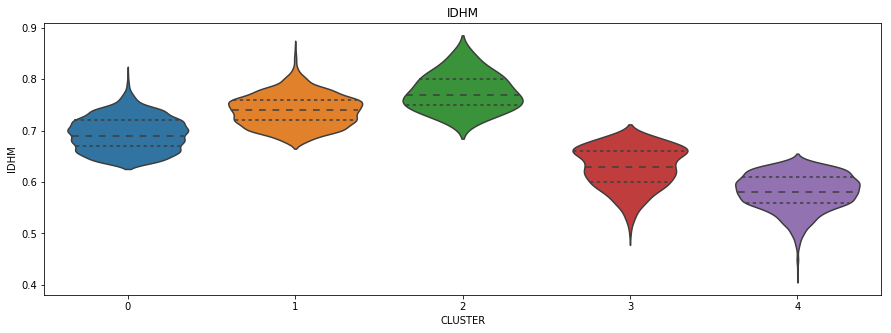

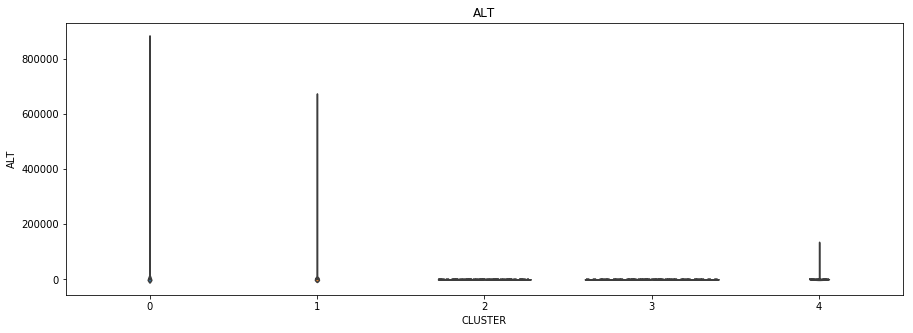

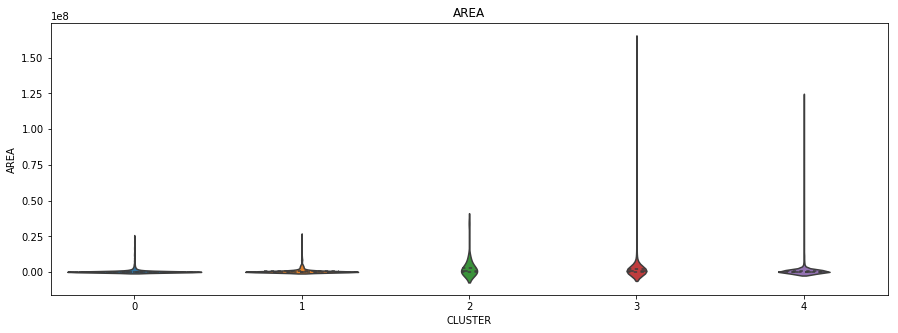

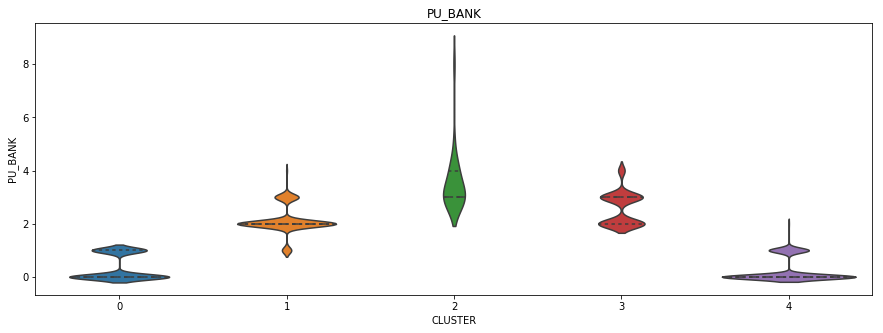

In [11]:
for coluna in base.drop(['CITY', 'CLUSTER'], axis=1).columns:    
    plt.figure(figsize=[15, 5])
    plt.title(coluna)
    sns.violinplot(x='CLUSTER', y=coluna, data=base, inner="quartile")
    plt.show()

## Conclusões

* O grupo 2 é composto apenas por cidades capitais e com mais bancos publicos
* Os grupos 0 e 4 são os grupos composto por cidades com as menores populações
* As cidades com mais area plantadas estão no grupo 1
* As cidades com o maior IDHM estão no grupo 2, enquanto as cidades com o menor IDHM estão no grupo 4
* As cidades com a maior altitude estão nos grupos 0 e 1
* As cidades com a maior area estão nos grupos 3 e 4
* As cidades com o maior numero de bancos publicos estão no grupo 2, enquanto as com menos bancos estão nos grupos 0 e 4